# Histograms

* Basic Idea: Use area to compare sample ratios, instead of point counts
* Easier to answer questios like: "How many voters are older than 30, when presented with a histogram, than a table or a rugplot."
* Both a visualization method and a data-storage format

Further reading:
- https://www.circonus.com/2018/05/effective-management-of-high-volume-numeric-data-with-histograms/

In [1]:
%run prelude.py

# Building your own Histogram

1. Define value range of histogram `bin_min`, `bin_max`
2. Divide range into bins `bin[k], ..., bin[k]`
3. The bins may have variying width 
4. Count the number of samples in each bin `sample_count[k]`
5. Draw a rectangle for each bin with height:
   - `h[k] = sample_count[k]` -- non normalized 
   - `h[k] = sample_count[k] / bin_width[k]` -- normalized case
   

In [2]:
import numpy as np
X = np.genfromtxt("../datasets/WebLatency.csv", delimiter=",")[:,2][:2000] - 85

In [4]:
# Step 1: Represent bins via list of left-edges
bin_left = [
    10, 15, 20, 50, 100, 150, 200, 250, 300, 400, 500, 700, 800, 900, 1000, 1500
]

bin_min = bin_left[0]
bin_max = bin_left[-1]
bins = [ [bin_left[i-1],bin_left[i]] for i in range(1, len(bin_left)) ]

print("Bins: ", bins)

Bins:  [[10, 15], [15, 20], [20, 50], [50, 100], [100, 150], [150, 200], [200, 250], [250, 300], [300, 400], [400, 500], [500, 700], [700, 800], [800, 900], [900, 1000], [1000, 1500]]


In [5]:
# Step2: Count number of samples in bins
def count(X, bins):
    def findBin(x, bins):
        for i, bin in enumerate(bins):
            left, right = bin
            if left <= x and x < right:
                return i
        return None
    
    count = [0] * len(bins)
    for x in X:
        i = findBin(x, bins)
        if i != None:
            count[i] += 1

    return count

sample_count = count(X, bins)

print("Counts:", sample_count)

Counts: [43, 200, 1666, 35, 3, 3, 23, 8, 2, 5, 6, 2, 1, 1, 2]


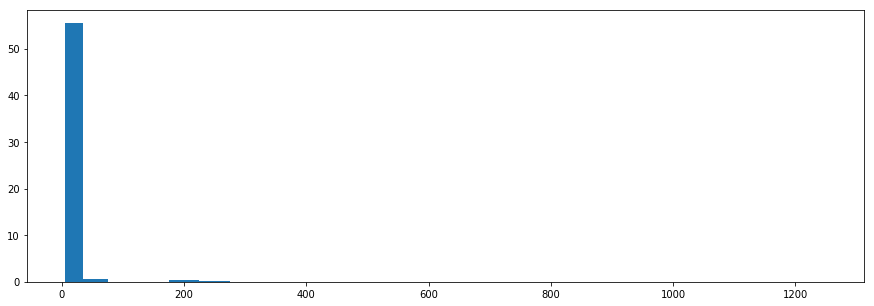

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# Step3: Plot bar chart
def my_hist(X, bins, normed=True, **kwargs):
    bin_left = [ l for l, r in bins ]
    bin_width = [ r-l  for l,r in bins ]
    bin_height = [ 
        float(c) / w if normed else c 
        for c,w in zip(count(X, bins), bin_width)
    ]
    plt.bar(bin_left,width=bin_width,height=bin_height, **kwargs)

plt.figure(figsize=(15,5))
my_hist(X,bins)

# The choice of bins influences the look of the histogram

In [8]:
def plot_hist(X,  bin_min, bin_max, bin_width):
    plt.figure(figsize=(15,5))
    bins =[ [i, i+bin_width] for i in np.arange(bin_min, bin_max, bin_width) ]
    my_hist(X,bins)
    print("Histogram with bin_width ", bin_width)
    plt.show()

In [16]:
math.sqrt(len(X))

44.721359549995796

Histogram with bin_width  44


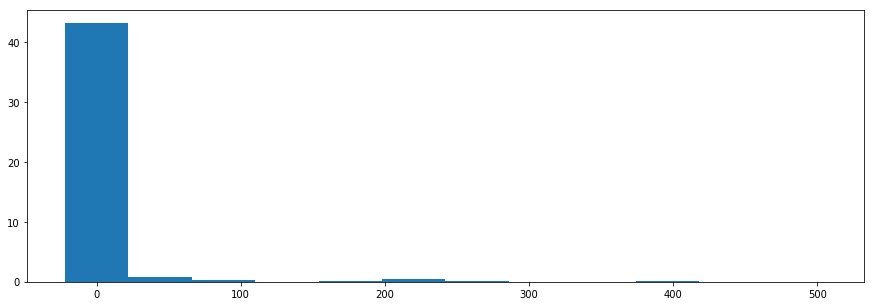

In [17]:
bin_min = 0
bin_max = 500
plot_hist(X, bin_min, bin_max, 44)

#--> Looks almost like the rugplot

Histogram with bin_width  50


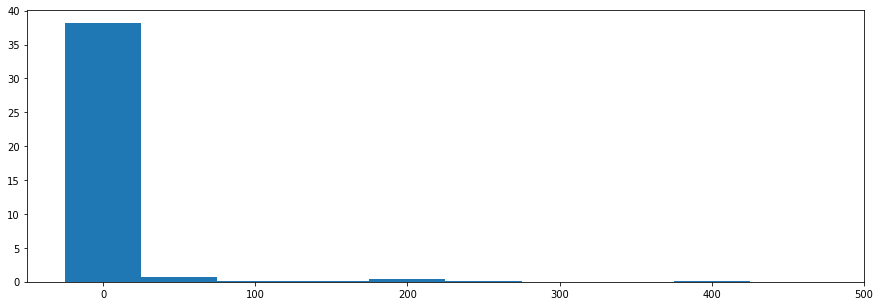

In [14]:
plot_hist(X, bin_min, bin_max, 50)

Histogram with bin_width  500


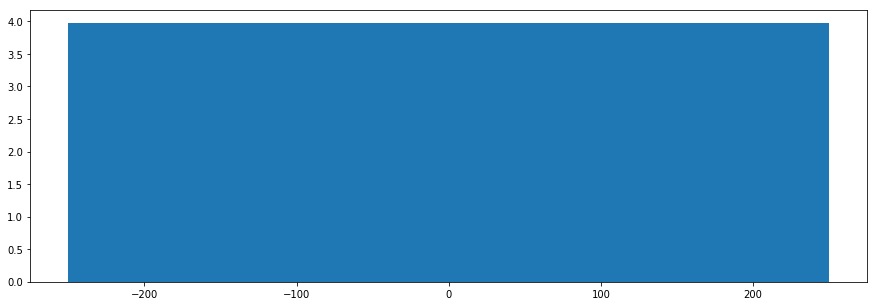

In [15]:
plot_hist(X, bin_min, bin_max, 500)

Histogram with bin_width  2000


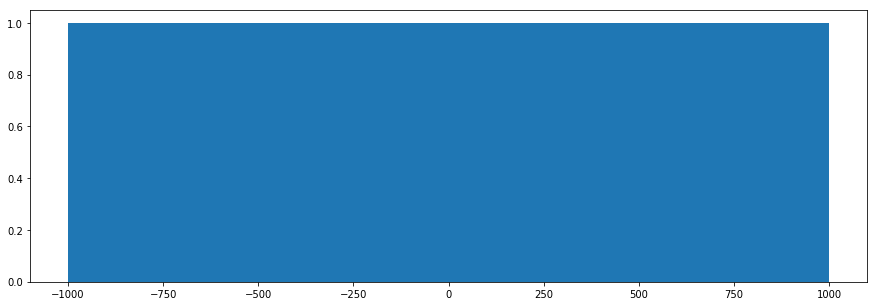

In [10]:
plot_hist(X, bin_min, bin_max, 2000)
# -> Only the total count is displayed

## Common bin-width choices

Remarks:
* Can convert `bin_count` and `bin_width` using relation $$ bin\_max - bin\_min = bin\_count \cdot bin\_width.$$

* Choices `bin_min=min(X)` and `bin_max=max(X)` are common. But: dependence on input data.

Choices for bin-width:

* Excel: Let $n$ be the number of samples, then:

  $$ bin\_count = \sqrt{n} $$

* Scott's normal reference rule

  $$ bin\_width = \frac{3.5 \sigma}{n^{1/3}} $$

  where $\sigma$ is the standard deviation (cf. later).
  This is optimal for random samples of normally distributed data, in a certain sense.

* Freedman–Diaconis rule

  $$ bin\_width = \frac{2 IQR}{n^{1/3}} $$
  
  where IQR is the inter-quartile range (cf. later). Like Scott's rule but more robust agains outliers.

# A pragmatic choice: Log Linear Histograms

Example: A decimal log-linear Histogram with precision=2 has bin boundaries:
  
    .... 1.0,  1.1,  1.2, ... 1.9,  2.0,  2.1, ...., 9.9; --- bin width = 0.1
         10.0, 11.0, 12.0 ... 19.0, 20.0, 21.0 ...., 99 ; --- bin width = 1
         ...

** Properties: **
* Captures large part of float range
* Bin boundaries do not depend on data! -> Can aggregate counts!
* Bin width increase with growing values
* Allows compact memory representation
* Two notable implementations:
  -  http://hdrhistogram.or/g
  - https://github.com/circonus-labs/libcircllhist/

In [18]:
# To be precise:
import math
def LL_bin_width(x):
    if x == 0: return 0
    sign = x / abs(x)
    return sign * 10 ** ( math.floor(math.log10(abs(x)) - 1 ) )

def LL_bin_left(x):
    w = LL_bin_width(x)
    if w == 0: return 0
    return math.floor(x / w) * w

def LL_bin_right(x):
    return bin_left(x) + bin_width(x)

In [19]:
[ LL_bin_width(x) for x in [0,0.01,0.1,1,2,9,9.9,10] ]

[0, 0.001, 0.01, 0.1, 0.1, 0.1, 0.1, 1.0]

In [20]:
def LL_hist(X):
    count = {}
    for x in X:
        l = LL_bin_left(x)
        count[l] = count.get(l,0) + 1
    return count

def LL_plot(H):
    bin_left = sorted(H.keys())
    bin_width = [ LL_bin_width(l) for l in bin_left ]
    bin_height = [ H[l] / LL_bin_width(l)
        for l in bin_left
    ]
    plt.figure(figsize=(15,5))
    plt.bar(bin_left,width=bin_width,height=bin_height)

In [21]:
LL_hist(X)

{95.0: 1,
 40.0: 16,
 92.0: 2,
 33.0: 52,
 27.0: 244,
 29.0: 80,
 25.0: 134,
 31.0: 65,
 32.0: 45,
 26.0: 188,
 24.0: 139,
 23.0: 92,
 37.0: 31,
 39.0: 10,
 36.0: 32,
 90.0: 4,
 230.0: 11,
 30.0: 89,
 300.0: 1,
 35.0: 27,
 28.0: 94,
 21.0: 90,
 20.0: 37,
 19.0: 93,
 270.0: 4,
 260.0: 1,
 530.0: 1,
 220.0: 11,
 430.0: 1,
 320.0: 1,
 780.0: 1,
 71.0: 1,
 18.0: 24,
 17.0: 56,
 700.0: 1,
 84.0: 3,
 110.0: 2,
 1200.0: 1,
 14.0: 43,
 630.0: 2,
 22.0: 118,
 38.0: 12,
 50.0: 1,
 34.0: 43,
 42.0: 7,
 41.0: 6,
 51.0: 1,
 57.0: 2,
 86.0: 3,
 82.0: 2,
 80.0: 3,
 590.0: 1,
 77.0: 2,
 16.0: 20,
 85.0: 1,
 180.0: 1,
 83.0: 1,
 46.0: 1,
 45.0: 4,
 47.0: 2,
 48.0: 2,
 54.0: 1,
 1400.0: 1,
 43.0: 5,
 15.0: 7,
 69.0: 1,
 44.0: 1,
 130.0: 1,
 940.0: 1,
 420.0: 2,
 480.0: 1,
 830.0: 1,
 280.0: 1,
 190.0: 2,
 490.0: 1,
 640.0: 1,
 94.0: 1,
 290.0: 2,
 240.0: 1,
 97.0: 1,
 78.0: 2,
 620.0: 1,
 70.0: 1,
 52.0: 1}

(0, 500)

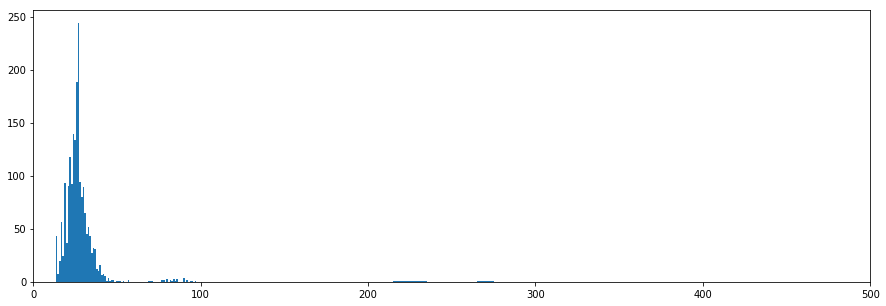

In [22]:
import seaborn as sns
LL_plot(LL_hist(X))
sns.rugplot(X,height=-0.05, color="grey")
plt.xlim(0,500)

# Histograms as Data Structure

Histograms can be conveniently represented as python dicts: "bin" => "count".

* Space use is proportinal to the number of bins used ~ data range.
* The number of inserted datapoints is not directly impacting it's size.

# Same thing with libcircllhist

source: https://github.com/circonus-labs/libcircllhist/

```
//! The histogram structure
//! Internals are regarded private and might change with version.
//! Only use the public methods to operate on this structure.
struct histogram {
  uint16_t allocd; //!< number of allocated bv pairs
  uint16_t used;   //!< number of used bv pairs
  uint32_t fast: 1;
  hist_allocator_t *allocator;
  struct hist_bv_pair *bvs; //!< pointer to bv-pairs
};
struct hist_bv_pair {
  hist_bucket_t bucket;
  uint64_t count;
};
typedef struct hist_bucket {
  int8_t val; //!< value * 10
  int8_t exp; //!< exponent -128 .. 127
} hist_bucket_t;
```

In [28]:
!pip install circllhist --upgrade

Requirement already up-to-date: circllhist in /opt/conda/lib/python3.6/site-packages (0.2.2)
Requirement not upgraded as not directly required: cffi in /opt/conda/lib/python3.6/site-packages (from circllhist) (1.11.4)
Requirement not upgraded as not directly required: pycparser in /opt/conda/lib/python3.6/site-packages (from cffi->circllhist) (2.18)
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [29]:
from circllhist import Circllhist

In [30]:
CH = Circllhist()
for x in X:
    CH.insert(x)

In [31]:
CH.to_dict()

{'+14e+000': 43,
 '+15e+000': 7,
 '+16e+000': 20,
 '+17e+000': 56,
 '+18e+000': 24,
 '+19e+000': 93,
 '+20e+000': 37,
 '+21e+000': 90,
 '+22e+000': 118,
 '+23e+000': 92,
 '+24e+000': 139,
 '+25e+000': 134,
 '+26e+000': 188,
 '+27e+000': 244,
 '+28e+000': 94,
 '+29e+000': 80,
 '+30e+000': 89,
 '+31e+000': 65,
 '+32e+000': 45,
 '+33e+000': 52,
 '+34e+000': 43,
 '+35e+000': 27,
 '+36e+000': 32,
 '+37e+000': 31,
 '+38e+000': 12,
 '+39e+000': 10,
 '+40e+000': 16,
 '+41e+000': 6,
 '+42e+000': 7,
 '+43e+000': 5,
 '+44e+000': 1,
 '+45e+000': 4,
 '+46e+000': 1,
 '+47e+000': 2,
 '+48e+000': 2,
 '+50e+000': 1,
 '+51e+000': 1,
 '+52e+000': 1,
 '+54e+000': 1,
 '+57e+000': 2,
 '+69e+000': 1,
 '+70e+000': 1,
 '+71e+000': 1,
 '+77e+000': 2,
 '+78e+000': 2,
 '+80e+000': 3,
 '+82e+000': 2,
 '+83e+000': 1,
 '+84e+000': 3,
 '+85e+000': 1,
 '+86e+000': 3,
 '+90e+000': 4,
 '+92e+000': 2,
 '+94e+000': 1,
 '+95e+000': 1,
 '+97e+000': 1,
 '+11e+001': 2,
 '+13e+001': 1,
 '+18e+001': 1,
 '+19e+001': 2,
 '+22e+00

In [32]:
plt.figure(figsize=(20,5))
circllhist_plot(CH) # from prelude.py
plt.xlim(0, 500)

AttributeError: 'Circllhist' object has no attribute 'compress_mbe'

# Example: Heatmaps of Log Linear Histograms

* Can use color coding for bin count
* Allows to show many histograms at once
* Harder to read off values
* Uses HDR Histogram

<figure>
<center><img src="../img/Circonus_Histogram.png"/></center>
<figcaption>A histogram metric.</figcaption>
</figure>


Traditionally only a single request per sampling period is recorded.
<figure>
<center><img src="../img/example_histogram_mean.png"/></center>
<figcaption>Histogram with mean value.</figcaption>
</figure>

Multimodal and logarithmic structures are not visible.

# Histograms are Suitable for High Frequency data

![](../img/bpf-histogram.png)


Blog: https://www.circonus.com/2018/05/linux-system-monitoring-with-ebpf/


# Histograms are Mergable

In [35]:
def merge(H, G):
    out = {}
    for b, c in H.items():
        out[b] = out.get(b, 0) + c
    for b, c in G.items():
        out[b] = out.get(b, 0) + c
    return out

In [36]:
H=LL_hist(X)

In [37]:
print(merge(H,H))

{95.0: 2, 40.0: 32, 92.0: 4, 33.0: 104, 27.0: 488, 29.0: 160, 25.0: 268, 31.0: 130, 32.0: 90, 26.0: 376, 24.0: 278, 23.0: 184, 37.0: 62, 39.0: 20, 36.0: 64, 90.0: 8, 230.0: 22, 30.0: 178, 300.0: 2, 35.0: 54, 28.0: 188, 21.0: 180, 20.0: 74, 19.0: 186, 270.0: 8, 260.0: 2, 530.0: 2, 220.0: 22, 430.0: 2, 320.0: 2, 780.0: 2, 71.0: 2, 18.0: 48, 17.0: 112, 700.0: 2, 84.0: 6, 110.0: 4, 1200.0: 2, 14.0: 86, 630.0: 4, 22.0: 236, 38.0: 24, 50.0: 2, 34.0: 86, 42.0: 14, 41.0: 12, 51.0: 2, 57.0: 4, 86.0: 6, 82.0: 4, 80.0: 6, 590.0: 2, 77.0: 4, 16.0: 40, 85.0: 2, 180.0: 2, 83.0: 2, 46.0: 2, 45.0: 8, 47.0: 4, 48.0: 4, 54.0: 2, 1400.0: 2, 43.0: 10, 15.0: 14, 69.0: 2, 44.0: 2, 130.0: 2, 940.0: 2, 420.0: 4, 480.0: 2, 830.0: 2, 280.0: 2, 190.0: 4, 490.0: 2, 640.0: 2, 94.0: 2, 290.0: 4, 240.0: 2, 97.0: 2, 78.0: 4, 620.0: 2, 70.0: 2, 52.0: 2}


# Compute Statistics from Histograms

* Counts
* Means
* Min/Max
* Median
* Percentiles (!)

In [38]:
def comp(a,b):
    print("Raw data:{: >10.3f}   /   Histogram:{:>10.3f}".format(a,b))

comp(CH.count(), len(X))
comp(CH.mean(), np.mean(X))
comp(CH.quantile(1), np.max(X))
comp(CH.quantile(0), np.min(X))
comp(CH.quantile(.5), np.median(X))
comp(CH.quantile(.9), np.percentile(X, 90))

Raw data:  2000.000   /   Histogram:  2000.000
Raw data:    37.313   /   Histogram:    37.171
Raw data:  1500.000   /   Histogram:  1435.600
Raw data:    14.000   /   Histogram:    14.200
Raw data:    26.782   /   Histogram:    26.800
Raw data:    36.625   /   Histogram:    36.400


In [39]:
%timeit np.percentile(X, 90)

53.7 µs ± 7.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [40]:
%timeit CH.quantile(.9)

2.18 µs ± 40.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
